In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve


digits = load_digits()

nDigits, nPixels = digits.data.shape

In [2]:
def displayDigits(nImages):
    """Function to display random selection of images from digit dataset
    INPUT
      -nImages: Integer to indicat how many images to display
    OUTPUT
      -none: Displays nImages randomly selected images int he digits data set"""

    # function to get factors of a integer
    def factors(n):    
        return set(reduce(list.__add__, 
                    ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
    
    # Choosing how many rows and columsn to disply
    fact = sorted(list(factors(nImages)))
    nCols = fact[len(fact)/2]
    nRows = nImages/nCols
    
    # Choosing images to display randomly
    diplayIdx = np.random.randint(nDigits, size=nImages)
    
    # Displaying images
    for i in range(len(diplayIdx)):
        p = plt.subplot(nRows,nCols,i+1)
        p.axis('off')
        plt.imshow(digits.images[diplayIdx[i]], 
                   cmap="gray",
                   interpolation="gaussian")      

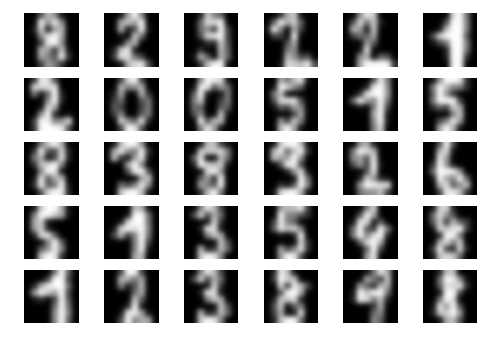

In [3]:
nImages = 30
displayDigits(nImages)  

In [4]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.1)

batchSize = X_train.shape[0]
nn = MLPClassifier(solver='adam', 
                   alpha=5,
                   hidden_layer_sizes=(18), 
                   activation="relu",
                   max_iter=10000,
                   batch_size=batchSize,
                   tol=1e-8)

nn.fit(X_train, y_train)

y_hat = nn.predict(X_test)

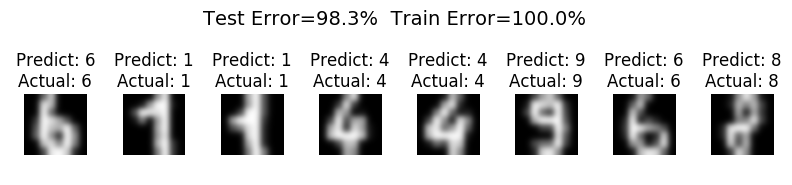

In [5]:
def plotResults(model, X_train, X_test, y_train, y_test, y_hat, numDisplayedPred = 8):
    trainError = sum(nn.predict(X_train)==y_train)*100.0/len(y_train)
    testError = sum(y_hat==y_test)*100.0/len(y_hat)
    numPredictions = len(y_test)
    plt.figure(figsize=[8,2.4])
    for i in range(numDisplayedPred):
        idx = np.random.randint(numPredictions)
        img = X_test[idx].reshape([8,8])
        p = plt.subplot(1, numDisplayedPred, i+1)
        p.axis("off")
        plt.imshow(img, cmap="gray", interpolation="gaussian")
        plt.title("Predict: {}\nActual: {}".format(y_hat[idx],y_test[idx]))
    plt.suptitle('Test Error={:0.1f}%  Train Error={:0.1f}%'.format(testError, trainError), 
                 fontsize=14)
    plt.tight_layout()

plotResults(nn, X_train, X_test, y_train, y_test, y_hat)

In [6]:
hiddenNode_range = range(2,31,2)

# Note: Batch size has to change to avoid a warning due to
#   Batch size set before is larger than the training data
#   used for validation curve
cv_partition = 5
nn.set_params(batch_size=digits.data.shape[0]/4)


h_train_scores, h_test_scores = validation_curve(estimator = nn, 
                                             X = digits.data, 
                                             y = digits.target, 
                                             param_name = "hidden_layer_sizes", 
                                             param_range=hiddenNode_range, 
                                             cv=cv_partition, 
                                             scoring="accuracy", 
                                             n_jobs=8)

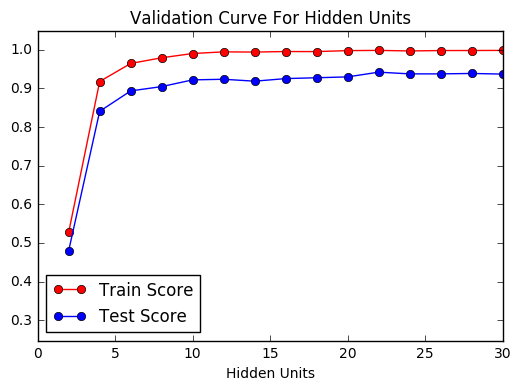

In [7]:
def plotValidationCurve(param_range, train_scores, test_scores, param_name=None):
    plt.plot(param_range, train_scores.mean(axis=1), 
             '-ro', label="Train Score")
    plt.plot(param_range, test_scores.mean(axis=1), 
             '-bo', label="Test Score")
    plt.ylim(0.99*np.min(test_scores),1.05)
    if param_name is None:
        plt.xlabel("Parameter Value")
        plt.title("Validation Curve")
    else: 
        plt.xlabel(param_name)
        plt.title("Validation Curve For {}".format(param_name))    
    plt.legend(loc="best")

plotValidationCurve(hiddenNode_range, 
                    h_train_scores, 
                    h_test_scores, 
                    param_name="Hidden Units")

In [8]:
hidden2Node_range = []
l1Node_range = range(5,37,2)
l2Node_range = range(5,37,2)

for i in l1Node_range:
    for j in l2Node_range:
        hidden2Node_range.append((i,j))

h2_train_scores, h2_test_scores = validation_curve(estimator = nn, 
                                             X = digits.data, 
                                             y = digits.target, 
                                             param_name = "hidden_layer_sizes", 
                                             param_range=hidden2Node_range, 
                                             cv=5, 
                                             scoring="accuracy", 
                                             n_jobs=8)

# Placing results in Data Frame for convinience
layer1 = map(lambda x: x[0], hidden2Node_range)
layer2 = map(lambda x: x[1], hidden2Node_range)
df = pd.DataFrame({"Layer1":layer1, 
                   "Layer2":layer2, 
                   "trainScore":h2_train_scores.mean(axis=1), 
                   "TestScore":h2_test_scores.mean(axis=1)})

In [9]:
# 3D plots are finicky and require meshgrids. 
X,Y = np.meshgrid(l1Node_range, l2Node_range)

TestScore = np.zeros([len(l1Node_range), len(l2Node_range)])
for i in xrange(0,len(X)):
    for j in xrange(0,len(Y)):
        TestScore[j,i] = df.TestScore[df.Layer1==l1Node_range[i]][df.Layer2==l2Node_range[j]]

TrainScore = np.zeros([len(l1Node_range), len(l2Node_range)])
for i in xrange(0,len(X)):
    for j in xrange(0,len(Y)):
        TrainScore[j,i] = df.trainScore[df.Layer1==l1Node_range[i]][df.Layer2==l2Node_range[j]]

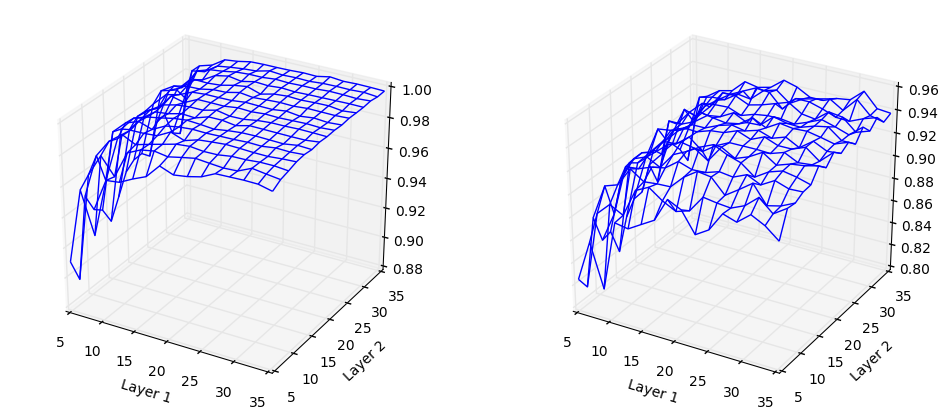

In [10]:
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X, Y, TrainScore, rstride=1, cstride=1)
ax.set_xlabel('Layer 1 Size'); ax.set_ylabel('Layer 2 Size')

ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(X, Y, TestScore, rstride=1, cstride=1)
ax.set_xlabel('Layer 1 Size'); ax.set_ylabel('Layer 2 Size')

It looks like when layer 1 has more than 10 nodes and layer 2 has more than 3 nodes, the proformance plateus for both the test and training sets. Since the training scores are almost all at 100%, we would probably benefit from having more training data. For my final model. I think I'll stick with 12 nodes in layer 1 and 15 nodes in layer 2

In [11]:
df.sort_values(["TestScore", "trainScore"], ascending=False).head(10)

,Layer1,Layer2,TestScore,trainScore
223,31,35,0.951052,0.997911
222,31,33,0.948751,0.997774
132,21,13,0.945444,0.996243
251,35,27,0.945435,0.998052
204,29,29,0.944944,0.997775
156,23,29,0.944878,0.997913
218,31,25,0.944859,0.998052
247,35,19,0.944386,0.997913
169,25,23,0.944349,0.996938
109,17,31,0.944325,0.997076


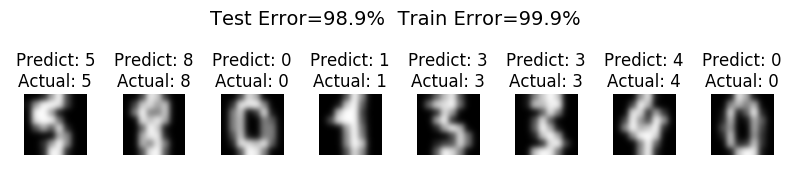

In [12]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.1)

nn.set_params(hidden_layer_sizes=(18,15), 
              tol=1e-10,
              max_iter=10000)
nn.fit(X_train, y_train)

y_hat = nn.predict(X_test)

plotResults(nn, X_train, X_test, y_train, y_test, y_hat)